In [2]:
import scipy
import os
import numpy as np
import pandas as pd
from fooof.utils.io import load_fooofgroup as load_fooofgroup
from natsort import natsorted 
import matplotlib as mpl
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rcParams['font.family'] = 'Arial'
plt.rcParams.update({'font.size': 14})
from sklearn.metrics import r2_score
from scipy.stats import spearmanr
import pickle
import imageio.v2 as imageio  # For saving GIFs
from enigmatoolbox.utils.parcellation import parcel_to_surface
from enigmatoolbox.plotting import plot_cortical
import statsmodels.api as sm
import scipy.stats as stats

with open("G:\\Drive condivisi\\AnalisiSegnaliEeg\\HD EEG\\Crisi_HDEEG\\ICA_pruned_reduced\\plot_indeces_organization", 'rb') as file:
    new_indices = pickle.load(file)


def baseline_correction_separate(power_data):
    """
    Applies baseline correction separately for each subject and each ROI.

    Parameters:
    - power_data: dict {subject_name: np.array of shape (68, 120, 2346)} 
      where each key corresponds to a subject, and values are the power spectrum.

    Returns:
    - corrected_data: dict {subject_name: np.array of shape (68, 120, 2346)}
      with baseline correction applied.
    """
    corrected_data = {}  # Dictionary to store results

    # Iterate over subjects
    for idx, (subj, values) in enumerate(power_data.items()):  # 29 subjects
        corrected_values = np.zeros_like(values)  # Initialize array for subject
        
        for roi in range(values.shape[0]):  # 68 ROIs
            baseline_activity = values[roi, 0, :]  # Baseline (shape: 2346)

            # Avoid division by zero
            baseline_activity = np.where(baseline_activity == 0, 1e-10, baseline_activity)

            # Apply correction across timepoints
            corrected_values[roi, :, :] = 10 * np.log10(values[roi, :, :] / baseline_activity)

        corrected_data[subj] = corrected_values  # Store corrected data for each subject

    return corrected_data

############################################################################################
def reorganize_roi_gradient(original_data, new_indices=new_indices):
  '''
  A function that reorder the atlas parcels for plot purposes

  Arguments
  ---------
    original_data: a list.
      the original wrong ordered data, output of reorder_hemispheres function
    new_indices: a list.
      a list of the indeces in the new order
  Returns
  -------
    x: an array.
      the reordered data used for the cortical plot
  '''
  x = [original_data[i] for i in new_indices]
  return(np.array(x))
############################################################################################

############################################################################################
def reorder_hemispheres(original_data, first_left = True):
  '''
  A function that reorder the atlas parcels for plot purposes.

  Arguments
  ---------
    original_data: a list.
      the original wrong ordered data, output of reorder_hemispheres function
    first_left: a boolean.
      True if we want all left hemispheres parcels before right hemisphere ones,
      False otherwise
  Returns
  -------
    ordered_data: a list.
      the reordered data used for the cortical plot. This will become the input for
      the reorganize_roi_gradient function
  '''
  left_h = []
  right_h = []
  for idx, val in enumerate(original_data):
    idx +=1
    if idx%2==0:
      right_h.append(val)
    else:
      left_h.append(val)
  if first_left:
    ordered_data = np.concatenate((left_h, right_h))
  else:
    ordered_data = np.concatenate((right_h, left_h))
  return ordered_data.tolist()

def mat_struct_to_dict(mat_obj):
    """ Recursively convert MATLAB structs to Python dictionaries """
    if isinstance(mat_obj, scipy.io.matlab.mio5_params.mat_struct):
        return {field: mat_struct_to_dict(getattr(mat_obj, field)) for field in mat_obj._fieldnames}
    elif isinstance(mat_obj, list):
        return [mat_struct_to_dict(item) for item in mat_obj]
    else:
        return mat_obj


def load_aperiodic_from_mat_files(parent_directory, aperiodic_component = 'exponent'):
    """
    Loads and extracts FOOOF aperiodic component data from all `.mat` files in the specified parent directory.
    This function iterates over all `.mat` files in the given directory, processes them by 
    and stores the results in a dictionary.

    Parameters:
    -----------
    parent_directory : str
        Path to the directory containing `.mat` files.
    aperiodic_component = str
        choose wich aperioding component to extract between 'exponent' and 'offset'

    Returns:
    --------
    data_dict : dict
        A dictionary where:
            - Keys are the subject names (extracted from file names, removing '_Sprint' if present).
            - Values are the extracted FOOOF exponent data from the `.mat` file.

    Notes:
    ------
    - Only files ending with `.mat` are considered.
    - The function assumes that the key in the loaded `.mat` structure matches the filename (without `.mat`).
    - Requires `scipy.io.loadmat` to load `.mat` files and `natsort.natsorted` for natural sorting.
    """
    # Initialize an empty dictionary to store results
    data_dict = {}

    # Iterate over each file in the parent directory, sorted naturally
    for file_name in natsorted(os.listdir(parent_directory)):  
        if file_name.endswith('.mat'):  # Consider only .mat files
            file_path = os.path.join(parent_directory, file_name)
            key_name = file_name.replace('.mat', '')
            dict_key = key_name.replace('_Sprint', '')

            print(f"Loading subject {dict_key} and extracting FOOOF exponent data...")

            # Load .mat file
            mat_data = scipy.io.loadmat(file_path, struct_as_record=False, squeeze_me=True)

            # Convert MATLAB structure to dictionary
            sprint_dict = mat_struct_to_dict(mat_data[key_name])

            # Extract and store exponent data
            data_dict[dict_key] = sprint_dict['Options']['SPRiNT']['topography'][aperiodic_component]

            # Free memory
            del sprint_dict  

    return data_dict

def compare_slopes(y1, y2):
    """
    Statistically compares the slopes of two time series using a t-test.
    
    Parameters:
        y1 (array-like): First time series (e.g., selected indices).
        y2 (array-like): Second time series (e.g., non-selected indices).
        
    Returns:
        dict: A dictionary containing the slopes, standard errors, t-statistic, and p-value.
    """
    # Create x values (time)
    x1 = np.arange(len(y1))
    x2 = np.arange(len(y2))
    
    # Fit OLS models
    model1 = sm.OLS(y1, sm.add_constant(x1)).fit()
    model2 = sm.OLS(y2, sm.add_constant(x2)).fit()
    
    # Extract slopes and standard errors
    beta1, se1 = model1.params[1], model1.bse[1]
    beta2, se2 = model2.params[1], model2.bse[1]
    
    # Compute t-statistic
    t_stat = (beta1 - beta2) / np.sqrt(se1**2 + se2**2)
    
    # Conservative degrees of freedom
    df = min(len(y1) - 2, len(y2) - 2)
    
    # Compute two-sided p-value
    p_value = 2 * stats.t.sf(np.abs(t_stat), df)
    
    return {
        "slope1": beta1,
        "slope2": beta2,
        "se1": se1,
        "se2": se2,
        "t_stat": t_stat,
        "p_value": p_value
    }


In [3]:
### LOADING ROIs NAME FROM EEGLAB DESIKAN ATLAS ###
labels = pd.read_excel('G:\\Drive condivisi\\AnalisiSegnaliEeg\\HD EEG\\Crisi_HDEEG\\Foof_res\\Desikan_regions.xlsx').values.tolist()
labels = [parcel_name[0].replace("'", "") for parcel_name in labels]
print(f'ROIs names: {labels}')

ROIs names: ['bankssts L', 'bankssts R', 'caudalanteriorcingulate L', 'caudalanteriorcingulate R', 'caudalmiddlefrontal L', 'caudalmiddlefrontal R', 'cuneus L', 'cuneus R', 'entorhinal L', 'entorhinal R', 'frontalpole L', 'frontalpole R', 'fusiform L', 'fusiform R', 'inferiorparietal L', 'inferiorparietal R', 'inferiortemporal L', 'inferiortemporal R', 'insula L', 'insula R', 'isthmuscingulate L', 'isthmuscingulate R', 'lateraloccipital L', 'lateraloccipital R', 'lateralorbitofrontal L', 'lateralorbitofrontal R', 'lingual L', 'lingual R', 'medialorbitofrontal L', 'medialorbitofrontal R', 'middletemporal L', 'middletemporal R', 'paracentral L', 'paracentral R', 'parahippocampal L', 'parahippocampal R', 'parsopercularis L', 'parsopercularis R', 'parsorbitalis L', 'parsorbitalis R', 'parstriangularis L', 'parstriangularis R', 'pericalcarine L', 'pericalcarine R', 'postcentral L', 'postcentral R', 'posteriorcingulate L', 'posteriorcingulate R', 'precentral L', 'precentral R', 'precuneus L'

In [4]:
### LOADING EXCEL FILE WITH THE INDICES OD RELEVANT ROIs x SUBJECT ###
file_path = "G:\\Drive condivisi\\AnalisiSegnaliEeg\\HD EEG\\Crisi_HDEEG\\PLOTS\\relevant_rois_indices.xlsx" 
df_relevant_rois = pd.read_excel(file_path)
# Extract indices and IDs
list_indices =  list(zip(df_relevant_rois["ID"].tolist(), list(df_relevant_rois["INDICES_strict"].tolist())))

In [5]:
import pickle

# Load the dictionary from the file
with open("G:\\Drive condivisi\\AnalisiSegnaliEeg\\HD EEG\\Crisi_HDEEG\\Foof_res_correct\\power_spectrum.pkl", 'rb') as file:
    power_spectrum_dict = pickle.load(file)

In [6]:
### LOADING POWER SPECTRUM FREQS ###
loaded_data = scipy.io.loadmat("G:\\Drive condivisi\\AnalisiSegnaliEeg\\HD EEG\\Crisi_HDEEG\\Foof_res_correct\\SJ_10_sz1_Sprint.mat", struct_as_record=False, squeeze_me=True)
sprint_dict = mat_struct_to_dict(loaded_data['SJ_10_sz1_Sprint'])
freqs = sprint_dict['Freqs']
del loaded_data
del sprint_dict

C:\Users\simon\AppData\Local\Temp\ipykernel_39876\2330993914.py:110: DeprecationWarning: Please use `mat_struct` from the `scipy.io.matlab` namespace, the `scipy.io.matlab.mio5_params` namespace is deprecated.
  if isinstance(mat_obj, scipy.io.matlab.mio5_params.mat_struct):


In [109]:
from scipy.stats import zscore

def process_power_spectrum(power_spectrum_dict, freqs, list_indices, compensated_1_over_f=True, normalized="per ROIs"):
    # Validate normalization method
    valid_normalization_options = {"none", "per ROIs", "per subject"}
    if normalized not in valid_normalization_options:
        raise ValueError(f"Invalid normalization option '{normalized}'. Choose from {valid_normalization_options}.")

    compensated_1f_power = power_spectrum_dict.copy()
    if compensated_1_over_f:
        compensated_1f_power = {subj: data * freqs for subj, data in power_spectrum_dict.items()}
    
    avg_selected , avg_not_selected = {}, {}
    # Process each ID and its corresponding indices
    for ID, indices in list_indices:
        if ID in compensated_1f_power:
            matrix = compensated_1f_power[ID]  # Shape (68, 120, 2346)

            # Convert indices from string to list of integers
            selected_indices = list(map(int, indices.split(",")))
            # Select columns corresponding to the indices
            selected_values = matrix[selected_indices, :, :]  # Shape (selected_indices, 120, 2346)
            not_selected_values = np.delete(matrix, selected_indices, axis=0)  # Remaining columns
            del matrix
            # Compute averages
            avg_selected[ID] = selected_values
            avg_not_selected[ID] = not_selected_values
            del selected_values, not_selected_values
    
    if normalized == "per ROIs":
        # Flatten all data into a single array for global mean/std
        all_selected_values = np.concatenate([values.reshape(-1) for values in avg_selected.values()])
        all_not_selected_values = np.concatenate([values.reshape(-1) for values in avg_not_selected.values()])

        # Compute global mean and std
        mean_all_selected, std_all_selected = np.mean(all_selected_values), np.std(all_selected_values)
        mean_all_not_selected, std_all_not_selected = np.mean(all_not_selected_values), np.std(all_not_selected_values)

        # Apply z-score normalization across all subjects
        for key in avg_selected:
            avg_selected[key] = (avg_selected[key] - mean_all_selected) / std_all_selected
        for key in avg_not_selected:
            avg_not_selected[key] = (avg_not_selected[key] - mean_all_not_selected) / std_all_not_selected

    elif normalized == "per subject":
        # Normalize each subject separately
        for key in avg_selected:
            mean_selected, std_selected = np.mean(avg_selected[key]), np.std(avg_selected[key])
            avg_selected[key] = (avg_selected[key] - mean_selected) / std_selected

        for key in avg_not_selected:
            mean_not_selected, std_not_selected = np.mean(avg_not_selected[key]), np.std(avg_not_selected[key])
            avg_not_selected[key] = (avg_not_selected[key] - mean_not_selected) / std_not_selected

    # Define frequency bands
    bands = {
        "DELTA": (2, 4), "THETA": (5, 7), "ALPHA": (8, 12), 
        "BETA": (13, 30), "GAMMA": (30, 40)
    }
    
    # Initialize new dictionary to store filtered values
    freq_data_selected_rois = {band: {} for band in bands}
    freq_data_non_selected_rois = {band: {} for band in bands}

    # Iterate over subjects in data_dict
    for subject, data in avg_selected.items():
        for band, (low, high) in bands.items():
            # Get indices of frequencies within the range
            freq_indices = np.where((freqs >= low) & (freqs <= high))[0]
            # Select the corresponding values from the last axis (frequencies)
            freq_data_selected_rois[band][subject] = data[:, :, freq_indices]
    # Iterate over subjects in data_dict
    for subject, data in avg_not_selected.items():
        for band, (low, high) in bands.items():
            # Get indices of frequencies within the range
            freq_indices = np.where((freqs >= low) & (freqs <= high))[0]
            # Select the corresponding values from the last axis (frequencies)
            freq_data_non_selected_rois[band][subject] = data[:, :, freq_indices]

    time_avg_data_selected = {band: [] for band in bands}
    time_std_data_selected = {band: [] for band in bands}

    # Iterate over each frequency band
    for band in freq_data_selected_rois:
        for subject, data in freq_data_selected_rois[band].items():
            # data has shape (n_selected_rois x 120 x band_freqs)
            # Compute mean along the freqs and selected_rois axes
            time_avg_data_selected[band].append(np.mean(data, axis=(0, 2)))
        time_avg_data_selected[band] = np.mean(np.array(time_avg_data_selected[band]), axis = 0)
        time_std_data_selected[band] = np.std(np.array(time_avg_data_selected[band]), axis = 0)

    time_avg_data_non_selected = {band: [] for band in bands}
    time_std_data_non_selected = {band: [] for band in bands}

    # Iterate over each frequency band
    for band in freq_data_non_selected_rois:
        for subject, data in freq_data_non_selected_rois[band].items():
            # Compute mean along the time axis (axis=1)
            time_avg_data_non_selected[band].append(np.mean(data, axis=(0, 2)))
        time_avg_data_non_selected[band] = np.mean(np.array(time_avg_data_non_selected[band]), axis = 0)
        time_std_data_non_selected[band] = np.std(np.array(time_avg_data_non_selected[band]), axis = 0)
    
    return time_avg_data_selected, time_std_data_selected, time_avg_data_non_selected, time_std_data_non_selected

In [8]:
mean_selected_rois, std_selected_rois, mean_not_selected_rois, std_not_selected_rois  = process_power_spectrum(power_spectrum_dict, freqs, 
                                                                                                      list_indices, compensated_1_over_f = False, normalized = 'none')

In [8]:
mean_selected_rois_normalized, std_selected_rois_normalized, mean_not_selected_rois_normalized, std_not_selected_rois_normalized  = process_power_spectrum(power_spectrum_dict, freqs, 
                                                                                                      list_indices, compensated_1_over_f = False, normalized = 'per ROIs')

In [9]:
mean_selected_rois_compensated, std_selected_rois_compensated, mean_not_selected_rois_compensated, std_not_selected_rois_compensated  = process_power_spectrum(power_spectrum_dict, freqs, 
                                                                                                      list_indices, compensated_1_over_f = True, normalized = 'none')

In [10]:
mean_selected_rois_compensated_normalized, std_selected_rois_compensated_normalized, mean_not_selected_rois_compensated_normalized, std_not_selected_rois_compensated_normalized  = process_power_spectrum(power_spectrum_dict, freqs, list_indices, compensated_1_over_f = True, normalized = 'per ROIs')

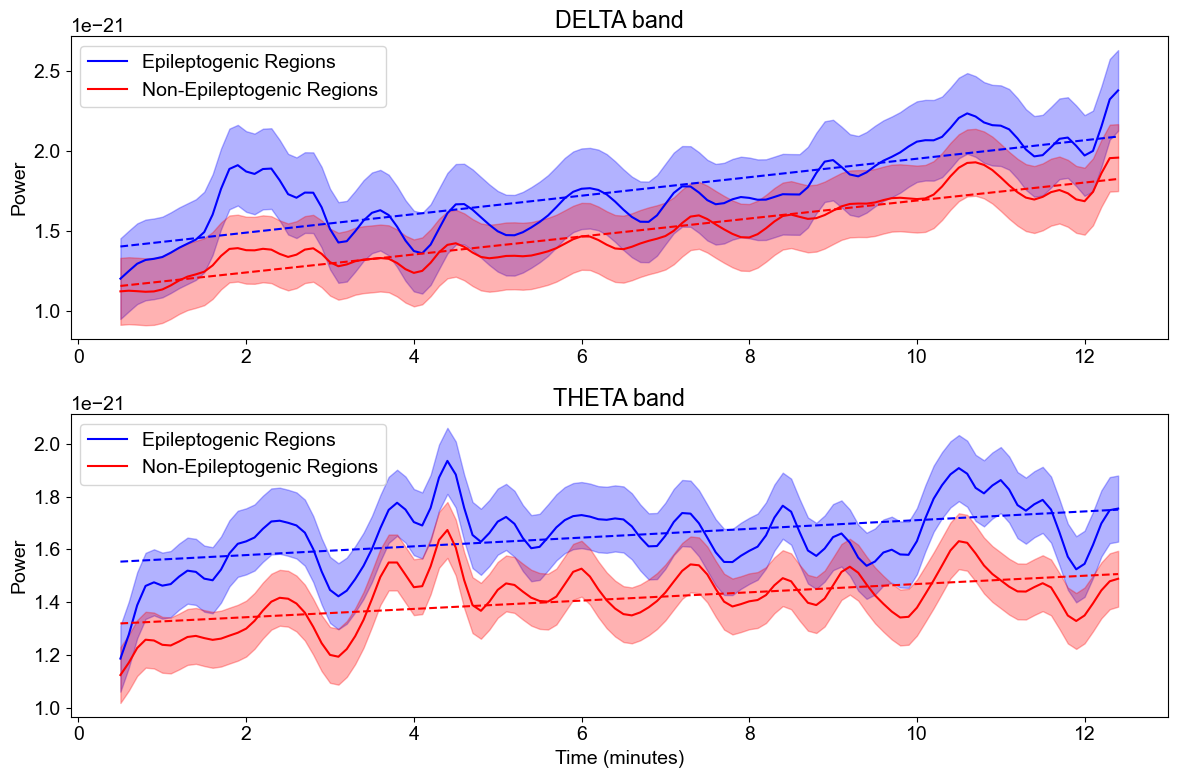

In [15]:
plot_mean_selected, plot_std_selected = mean_selected_rois_compensated , std_selected_rois_compensated
plot_mean_not_selected, plot_std_not_selected = mean_not_selected_rois_compensated  , std_not_selected_rois_compensated
# Create a figure and a set of subplots (5 rows, 1 column)
fig, axes = plt.subplots(2, 1, figsize=(12, 8))  # 5 plots vertically stacked


# Parameters
sampling_rate = 256  # Hz
signal_duration_sec = 13 * 60  # 780 seconds
window_length_sec = 60
step_size_sec = window_length_sec * (1 - 0.9)  # 6 seconds
num_segments = 121  # already known

# Generate time vector (window centers) in seconds
window_start_times = np.arange(0, step_size_sec * num_segments, step_size_sec)
window_center_times = window_start_times + (window_length_sec / 2)

# Convert to minutes
window_center_times_min = (window_center_times / 60)[:120]

selected_bands = ['DELTA', 'THETA']
# Iterate through the dictionary and plot each band on a separate subplot
#for i, (band, values) in enumerate(plot_mean_selected.items()):
for i, band in enumerate(selected_bands):
    ax = axes[i]  # Get the subplot axis for the current band
    
    x = window_center_times_min

    # Plot Epileptogenic ROIs
    y_sel = plot_mean_selected[band]
    ax.plot(x, y_sel, label='Epileptogenic Regions', color='blue')
    ax.fill_between(x, y_sel - plot_std_selected[band], y_sel + plot_std_selected[band], color='blue', alpha=0.3)

    # Add linear regression for Epileptogenic ROIs
    coeffs_sel = np.polyfit(x, y_sel, 1)
    ax.plot(x, np.polyval(coeffs_sel, x), linestyle='--', color='blue')

    # Plot Non-Epileptogenic ROIs
    y_non = plot_mean_not_selected[band]
    ax.plot(x, y_non, label='Non-Epileptogenic Regions', color='red')
    ax.fill_between(x, y_non - plot_std_not_selected[band], y_non + plot_std_not_selected[band], color='red', alpha=0.3)

    # Add linear regression for Non-Epileptogenic ROIs
    coeffs_non = np.polyfit(x, y_non, 1)
    ax.plot(x, np.polyval(coeffs_non, x), linestyle='--', color='red')


    # Axis labels and title
    if i == 1:
        ax.set_xlabel("Time (minutes)")
    ax.set_ylabel("Power")
    ax.set_title(f"{band} band")
    
    # Add legend
    ax.legend(loc = 'upper left')

# Adjust layout to avoid overlap
plt.tight_layout()
#plt.show()

plt.savefig("G:\\Drive condivisi\\AnalisiSegnaliEeg\\HD EEG\\Crisi_HDEEG\\PLOTS\\immagini finali\\fig 1\\power_spectra_preictal.png",dpi = 700)

In [28]:
mean_selected_rois_compensated.keys()

dict_keys(['DELTA', 'THETA', 'ALPHA', 'BETA', 'GAMMA'])

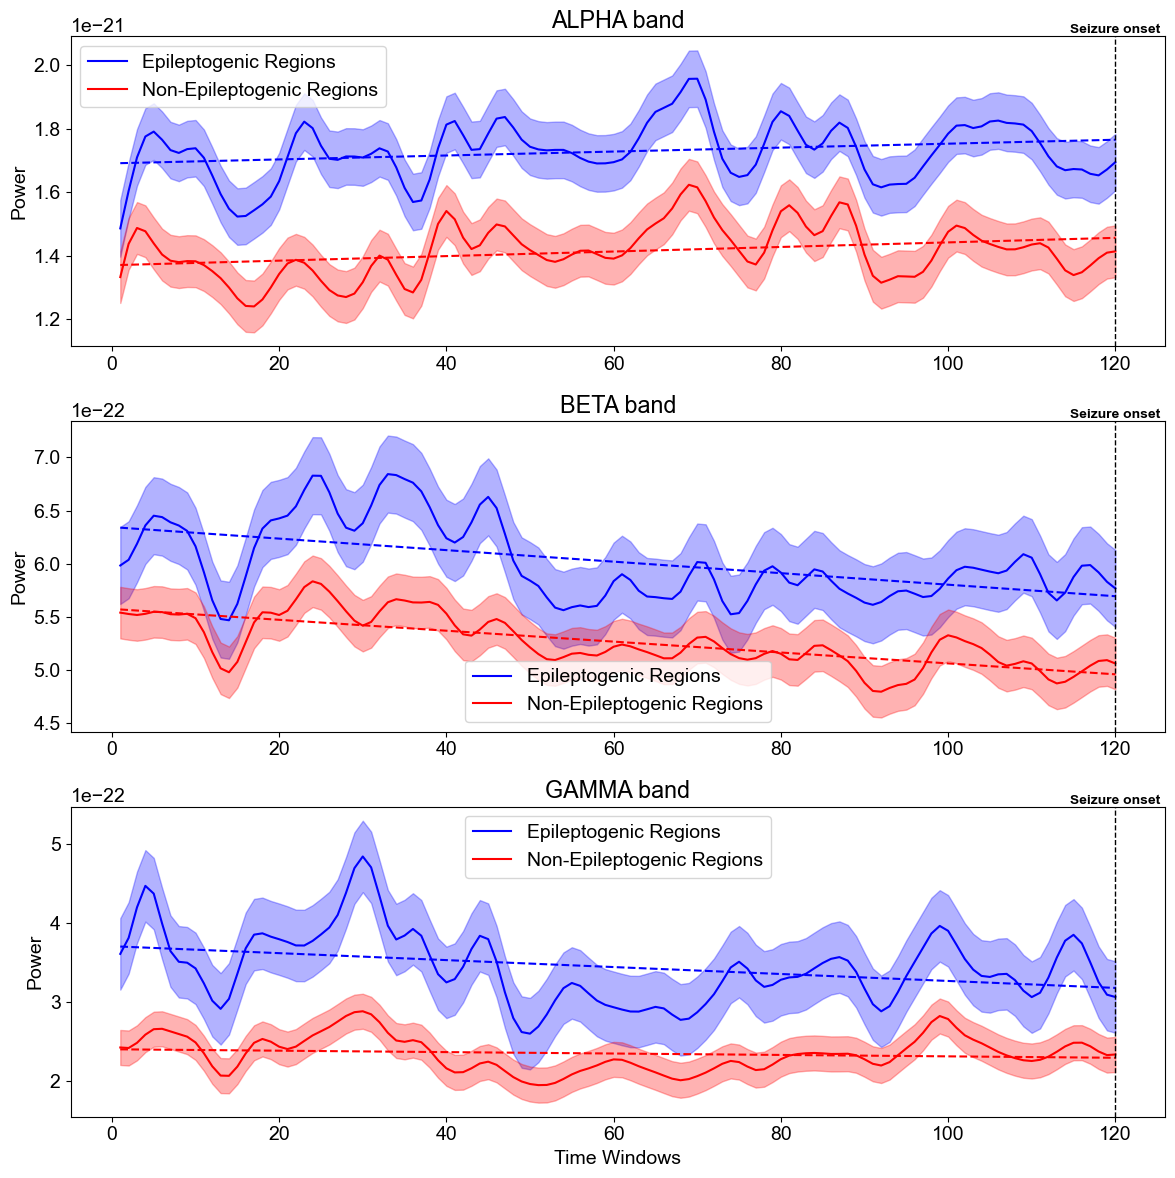

In [102]:
plot_mean_selected, plot_std_selected = mean_selected_rois_compensated , std_selected_rois_compensated
plot_mean_not_selected, plot_std_not_selected = mean_not_selected_rois_compensated  , std_not_selected_rois_compensated
# Create a figure and a set of subplots (5 rows, 1 column)
fig, axes = plt.subplots(3, 1, figsize=(12, 12))  # 5 plots vertically stacked

selected_bands = ['ALPHA', 'BETA', 'GAMMA']
# Iterate through the dictionary and plot each band on a separate subplot
#for i, (band, values) in enumerate(plot_mean_selected.items()):
for i, band in enumerate(selected_bands):
    ax = axes[i]  # Get the subplot axis for the current band
    
    x = np.arange(1, len(plot_mean_selected[band]) + 1)

    # Plot Epileptogenic ROIs
    y_sel = plot_mean_selected[band]
    ax.plot(x, y_sel, label='Epileptogenic Regions', color='blue')
    ax.fill_between(x, y_sel - plot_std_selected[band], y_sel + plot_std_selected[band], color='blue', alpha=0.3)

    # Add linear regression for Epileptogenic ROIs
    coeffs_sel = np.polyfit(x, y_sel, 1)
    ax.plot(x, np.polyval(coeffs_sel, x), linestyle='--', color='blue')

    # Plot Non-Epileptogenic ROIs
    y_non = plot_mean_not_selected[band]
    ax.plot(x, y_non, label='Non-Epileptogenic Regions', color='red')
    ax.fill_between(x, y_non - plot_std_not_selected[band], y_non + plot_std_not_selected[band], color='red', alpha=0.3)

    # Add linear regression for Non-Epileptogenic ROIs
    coeffs_non = np.polyfit(x, y_non, 1)
    ax.plot(x, np.polyval(coeffs_non, x), linestyle='--', color='red')

    # Add vertical black line at x=120 with label
    ax.axvline(x=120, color='black', linestyle='--', linewidth=1)
    # Add label on top of the line
    ax.text(120, ax.get_ylim()[1], "Seizure onset", color='black',
            ha='center', va='bottom', fontsize=10, fontweight='bold')
    # Axis labels and title
    if i == 2:
        ax.set_xlabel("Time Windows")
    ax.set_ylabel("Power")
    ax.set_title(f"{band} band")
    
    # Add legend
    ax.legend()

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

In [103]:
compensated_delta_epi_nonepi = compare_slopes(mean_selected_rois_compensated['DELTA'], mean_not_selected_rois_compensated['DELTA'])
print(f'Comparison between delta power in epileptogenics ROIs vs non epileptogenics ROIs T = {compensated_delta_epi_nonepi["t_stat"]}, pval = {compensated_delta_epi_nonepi["p_value"]}')

compensated_theta_epi_nonepi = compare_slopes(mean_selected_rois_compensated['THETA'], mean_not_selected_rois_compensated['THETA'])
print(f'Comparison between theta power in epileptogenics ROIs vs non epileptogenics ROIs T = {compensated_theta_epi_nonepi["t_stat"]}, pval = {compensated_theta_epi_nonepi["p_value"]}')

Comparison between delta power in epileptogenics ROIs vs non epileptogenics ROIs T = 0.3413118315894265, pval = 0.7334758579325487
Comparison between theta power in epileptogenics ROIs vs non epileptogenics ROIs T = 0.2160972204023556, pval = 0.8292850853703418


In [104]:
compensated_gamma_epi_nonepi = compare_slopes(mean_selected_rois_compensated['GAMMA'], mean_not_selected_rois_compensated['GAMMA'])
print(f'Comparison between gamma power in epileptogenics ROIs vs non epileptogenics ROIs T = {compensated_gamma_epi_nonepi["t_stat"]}, pval = {compensated_gamma_epi_nonepi["p_value"]}')

Comparison between gamma power in epileptogenics ROIs vs non epileptogenics ROIs T = -2.7506667798182436, pval = 0.006885322382626111


In [37]:
print(compensated_theta_epi_nonepi)

{'slope1': 1.653630374226037e-24, 'slope2': 1.5711507870929954e-24, 'se1': 2.958253626758102e-25, 'se2': 2.4117538096511563e-25, 't_stat': 0.2160972204023556, 'p_value': 0.8292850853703418}


#### RESTING STATE POWER ANALYSES ####

In [98]:
def load_aperiodic_from_mat_files(parent_directory, aperiodic_component = 'exponent'):
    """
    Loads and extracts FOOOF aperiodic component data from all `.mat` files in the specified parent directory.
    This function iterates over all `.mat` files in the given directory, processes them by 
    and stores the results in a dictionary.

    Parameters:
    -----------
    parent_directory : str
        Path to the directory containing `.mat` files.
    aperiodic_component = str
        choose wich aperioding component to extract between 'exponent' and 'offset'

    Returns:
    --------
    data_dict : dict
        A dictionary where:
            - Keys are the subject names (extracted from file names, removing '_Sprint' if present).
            - Values are the extracted FOOOF exponent data from the `.mat` file.

    Notes:
    ------
    - Only files ending with `.mat` are considered.
    - The function assumes that the key in the loaded `.mat` structure matches the filename (without `.mat`).
    - Requires `scipy.io.loadmat` to load `.mat` files and `natsort.natsorted` for natural sorting.
    """
    # Initialize an empty dictionary to store results
    data_dict = {}

    # Iterate over each file in the parent directory, sorted naturally
    for file_name in natsorted(os.listdir(parent_directory)):  
        if file_name.endswith('.mat'):  # Consider only .mat files
            file_path = os.path.join(parent_directory, file_name)
            key_name = file_name.replace('.mat', '')
            dict_key = key_name.replace('_rest_SPRINT', '')

            print(f"Loading subject {dict_key} and extracting POWER SPECTRA data...")

            # Load .mat file
            mat_data = scipy.io.loadmat(file_path, struct_as_record=False, squeeze_me=True)

            # Convert MATLAB structure to dictionary
            sprint_dict = mat_struct_to_dict(mat_data[key_name])

            # Extract and store exponent data
            data_dict[dict_key] = sprint_dict['TF']

            # Free memory
            del sprint_dict  

    return data_dict

In [ ]:
#power_spectra_dict = load_aperiodic_from_mat_files("G:\\Drive condivisi\\AnalisiSegnaliEeg\\HD EEG\\Crisi_HDEEG\\SPRINT_resting")

Loading subject SJ_10 and extracting POWER SPECTRA data...


C:\Users\simon\AppData\Local\Temp\ipykernel_12696\646411272.py:104: DeprecationWarning: Please use `mat_struct` from the `scipy.io.matlab` namespace, the `scipy.io.matlab.mio5_params` namespace is deprecated.
  if isinstance(mat_obj, scipy.io.matlab.mio5_params.mat_struct):


Loading subject SJ_39 and extracting POWER SPECTRA data...
Loading subject SJ_46 and extracting POWER SPECTRA data...
Loading subject SJ_47 and extracting POWER SPECTRA data...
Loading subject SJ_60 and extracting POWER SPECTRA data...
Loading subject SJ_63 and extracting POWER SPECTRA data...
Loading subject SJ_64 and extracting POWER SPECTRA data...
Loading subject SJ_67 and extracting POWER SPECTRA data...
Loading subject SJ_68 and extracting POWER SPECTRA data...
Loading subject SJ_83 and extracting POWER SPECTRA data...
Loading subject SJ_103 and extracting POWER SPECTRA data...
Loading subject SJ_107 and extracting POWER SPECTRA data...
Loading subject SJ_111 and extracting POWER SPECTRA data...
Loading subject SJ_115 and extracting POWER SPECTRA data...
Loading subject SJ_159 and extracting POWER SPECTRA data...
Loading subject SJ_176 and extracting POWER SPECTRA data...
Loading subject SJ_185 and extracting POWER SPECTRA data...
Loading subject SJ_205 and extracting POWER SPECT

In [106]:
with open("G:\\Drive condivisi\\AnalisiSegnaliEeg\\HD EEG\\Crisi_HDEEG\\SPRINT_resting\\resting_power_spectra.pkl", 'rb') as f:
    resting_power_spectra_dict = pickle.load(f)

In [107]:
list_indices_resting = [(key.split('_sz')[0], value) for key, value in list_indices]
list_indices_resting = natsorted(tuple(set(list_indices_resting)))

# removing 2 subjects that are not in the fooof exp interictal data
for index in [18,10]:
    del list_indices_resting[index]

In [110]:
resting_mean_selected_rois, resting_std_selected_rois, resting_mean_not_selected_rois, resting_std_not_selected_rois  = process_power_spectrum(resting_power_spectra_dict, freqs, 
                                                                                                      list_indices_resting, compensated_1_over_f = False, normalized = 'none')

In [35]:
resting_mean_selected_rois_normalized, resting_std_selected_rois_normalized, resting_mean_not_selected_rois_normalized, resting_std_not_selected_rois_normalized  = process_power_spectrum(resting_power_spectra_dict, freqs, 
                                                                                                      list_indices_resting, compensated_1_over_f = False, normalized = 'per ROIs')

In [118]:
resting_mean_selected_rois_compensated, resting_std_selected_rois_compensated, resting_mean_not_selected_rois_compensated, resting_std_not_selected_rois_compensated  = process_power_spectrum(resting_power_spectra_dict, freqs, 
                                                                                                      list_indices_resting, compensated_1_over_f = True, normalized = 'none')

In [37]:
resting_mean_selected_rois_compensated_normalized, resting_std_selected_rois_compensated_normalized, resting_mean_not_selected_rois_compensated_normalized, resting_std_not_selected_rois_compensated_normalized  = process_power_spectrum(resting_power_spectra_dict, freqs, list_indices_resting, compensated_1_over_f = True, normalized = 'per ROIs')

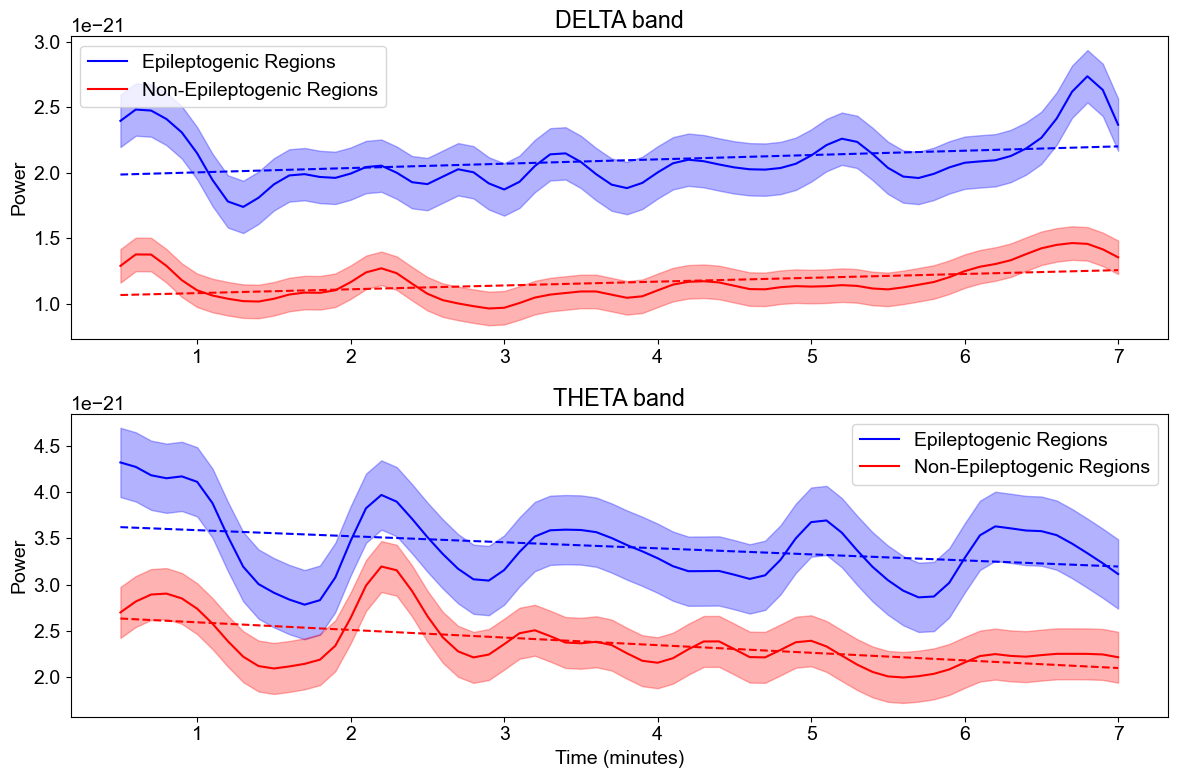

In [ ]:
plot_mean_selected, plot_std_selected = resting_mean_selected_rois_compensated , resting_std_selected_rois_compensated
plot_mean_not_selected, plot_std_not_selected = resting_mean_not_selected_rois_compensated  , resting_std_not_selected_rois_compensated
# Create a figure and a set of subplots (5 rows, 1 column)
fig, axes = plt.subplots(2, 1, figsize=(12, 8))  # 5 plots vertically stacked


# Parameters
sampling_rate = 256  # Hz
signal_duration_sec = 7.5 * 60  # 780 seconds
window_length_sec = 60
step_size_sec = window_length_sec * (1 - 0.9)  # 6 seconds
num_segments = 71  # already known

# Generate time vector (window centers) in seconds
window_start_times = np.arange(0, step_size_sec * num_segments, step_size_sec)
window_center_times = window_start_times + (window_length_sec / 2)

# Convert to minutes
window_center_times_min = (window_center_times / 60)[:66]


selected_bands = ['DELTA', 'THETA']
# Iterate through the dictionary and plot each band on a separate subplot
#for i, (band, values) in enumerate(plot_mean_selected.items()):
for i, band in enumerate(selected_bands):
    ax = axes[i]  # Get the subplot axis for the current band
    
    x = window_center_times_min

    # Plot Epileptogenic ROIs
    y_sel = plot_mean_selected[band]
    ax.plot(x, y_sel, label='Epileptogenic Regions', color='blue')
    ax.fill_between(x, y_sel - plot_std_selected[band], y_sel + plot_std_selected[band], color='blue', alpha=0.3)

    # Add linear regression for Epileptogenic ROIs
    coeffs_sel = np.polyfit(x, y_sel, 1)
    ax.plot(x, np.polyval(coeffs_sel, x), linestyle='--', color='blue')

    # Plot Non-Epileptogenic ROIs
    y_non = plot_mean_not_selected[band]
    ax.plot(x, y_non, label='Non-Epileptogenic Regions', color='red')
    ax.fill_between(x, y_non - plot_std_not_selected[band], y_non + plot_std_not_selected[band], color='red', alpha=0.3)

    # Add linear regression for Non-Epileptogenic ROIs
    coeffs_non = np.polyfit(x, y_non, 1)
    ax.plot(x, np.polyval(coeffs_non, x), linestyle='--', color='red')

    # Axis labels and title
    if i == 1:
        ax.set_xlabel("Time (minutes)")
    ax.set_ylabel("Power")
    ax.set_title(f"{band} band")
    
    # Add legend
    ax.legend()

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()

#plt.savefig("G:\\Drive condivisi\\AnalisiSegnaliEeg\\HD EEG\\Crisi_HDEEG\\PLOTS\\immagini finali\\fig 1\\power_spectra_resting_state.png",dpi = 700)

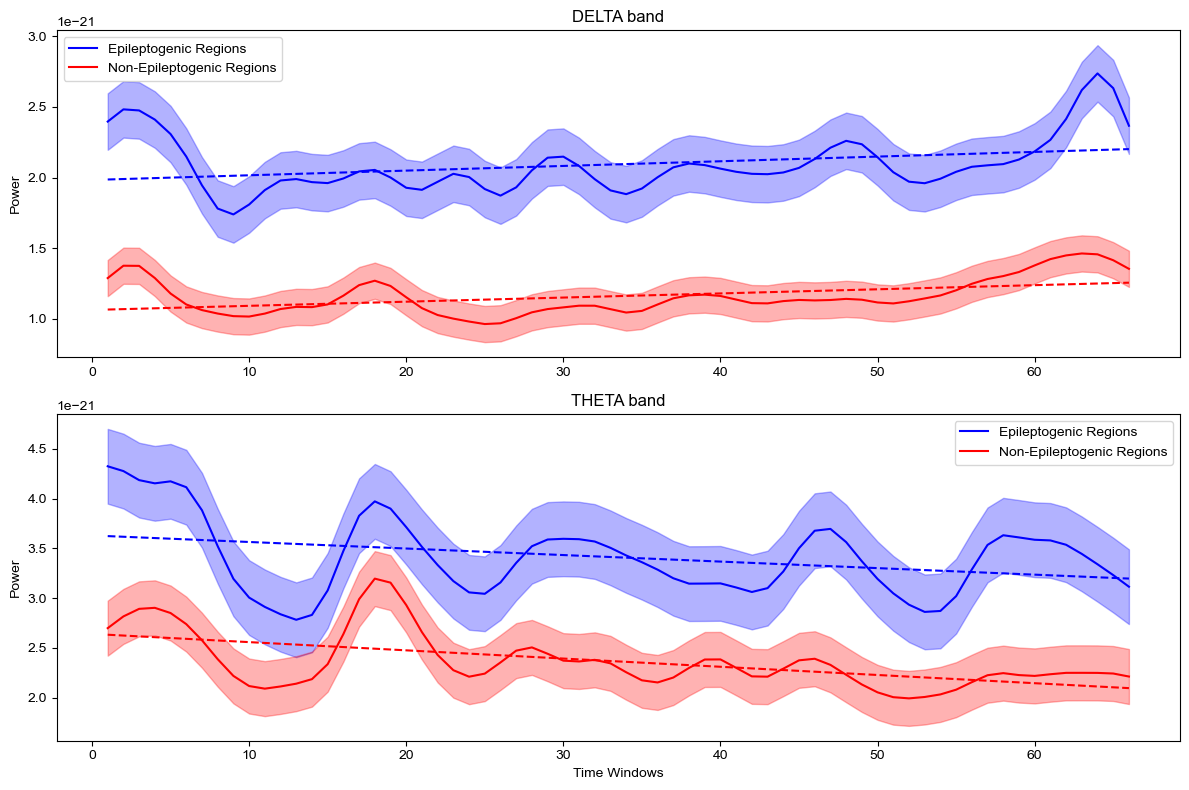

In [ ]:
plot_mean_selected, plot_std_selected = resting_mean_selected_rois_compensated , resting_std_selected_rois_compensated
plot_mean_not_selected, plot_std_not_selected = resting_mean_not_selected_rois_compensated  , resting_std_not_selected_rois_compensated
# Create a figure and a set of subplots (5 rows, 1 column)
fig, axes = plt.subplots(2, 1, figsize=(12, 8))  # 5 plots vertically stacked

# Assuming standard_deviation_dict is the dictionary that contains the standard deviations for each band
# Example: standard_deviation_dict = {'band1': [std_values], 'band2': [std_values], ...}

# Iterate through the dictionary and plot each band on a separate subplot
selected_bands = ['DELTA', 'THETA']

#for i, (band, values) in enumerate(plot_mean_selected.items()):
for i, band in enumerate(selected_bands): 
    ax = axes[i]  # Get the subplot axis for the current band

    x = np.arange(1, len(plot_mean_selected[band]) + 1)

    # Plot Epileptogenic ROIs
    y_sel = plot_mean_selected[band]
    ax.plot(x, y_sel, label='Epileptogenic Regions', color='blue')
    ax.fill_between(x, y_sel - plot_std_selected[band], y_sel + plot_std_selected[band], color='blue', alpha=0.3)

    # Add linear regression for Epileptogenic ROIs
    coeffs_sel = np.polyfit(x, y_sel, 1)
    ax.plot(x, np.polyval(coeffs_sel, x), linestyle='--', color='blue')

    # Plot Non-Epileptogenic ROIs
    y_non = plot_mean_not_selected[band]
    ax.plot(x, y_non, label='Non-Epileptogenic Regions', color='red')
    ax.fill_between(x, y_non - plot_std_not_selected[band], y_non + plot_std_not_selected[band], color='red', alpha=0.3)

    # Add linear regression for Non-Epileptogenic ROIs
    coeffs_non = np.polyfit(x, y_non, 1)
    ax.plot(x, np.polyval(coeffs_non, x), linestyle='--', color='red')

    # Axis labels and title
    if i == 1:
        ax.set_xlabel("Time Windows")
    ax.set_ylabel("Power")
    ax.set_title(f"{band} band")
    
    # Add legend
    ax.legend()

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()


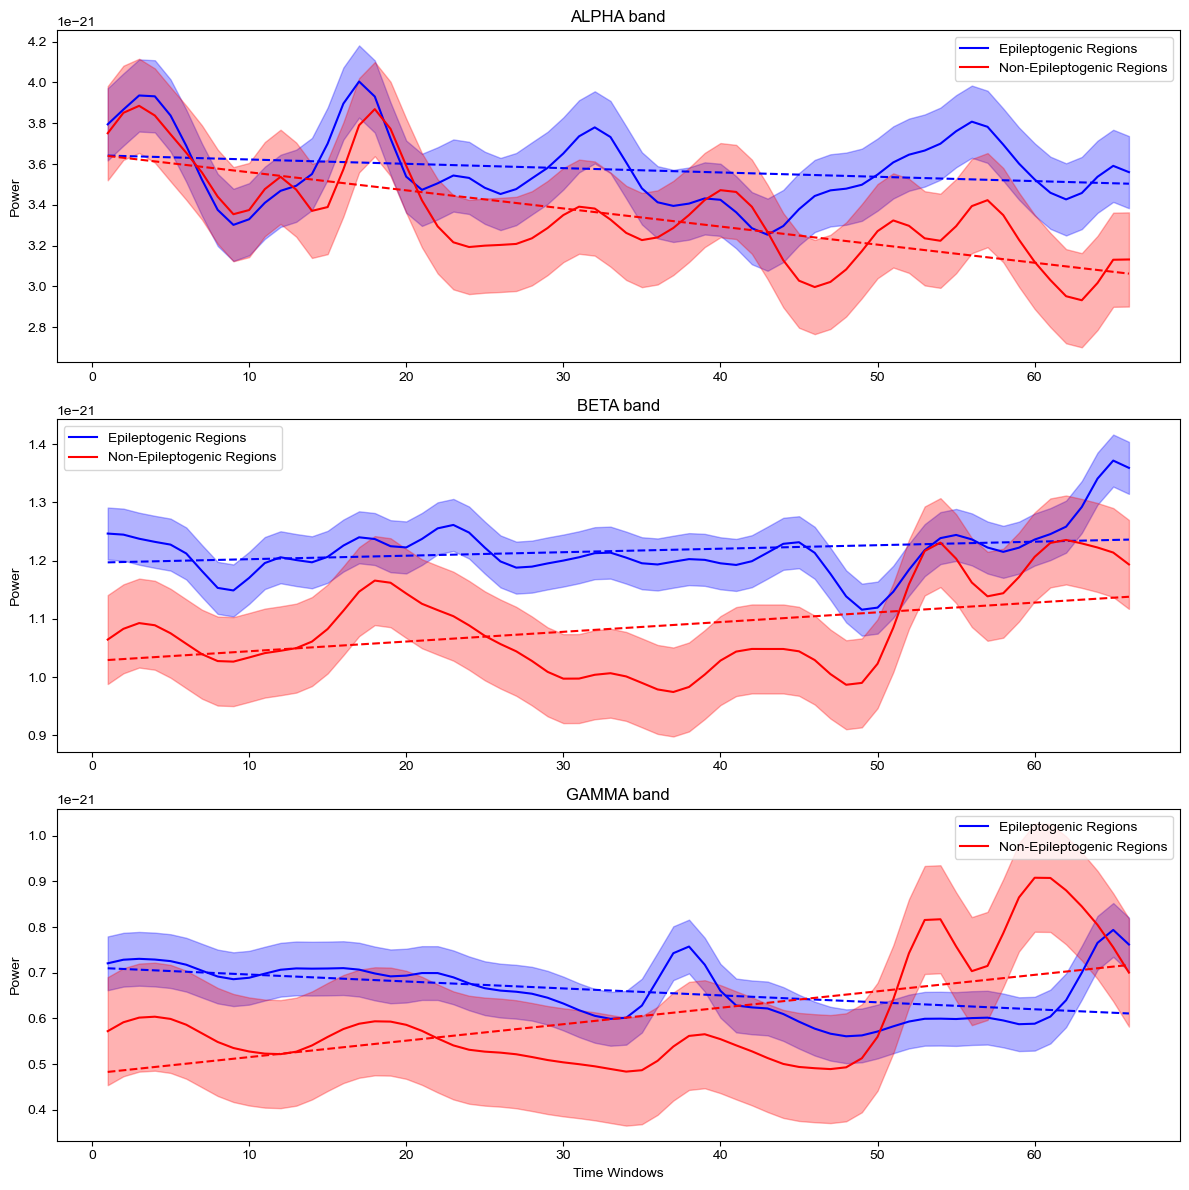

In [52]:
fig, axes = plt.subplots(3, 1, figsize=(12, 12))  # 5 plots vertically stacked

# Assuming standard_deviation_dict is the dictionary that contains the standard deviations for each band
# Example: standard_deviation_dict = {'band1': [std_values], 'band2': [std_values], ...}

# Iterate through the dictionary and plot each band on a separate subplot
selected_bands = ['ALPHA', 'BETA', 'GAMMA']

#for i, (band, values) in enumerate(plot_mean_selected.items()):
for i, band in enumerate(selected_bands): 
    ax = axes[i]  # Get the subplot axis for the current band

    x = np.arange(1, len(plot_mean_selected[band]) + 1)

    # Plot Epileptogenic ROIs
    y_sel = plot_mean_selected[band]
    ax.plot(x, y_sel, label='Epileptogenic Regions', color='blue')
    ax.fill_between(x, y_sel - plot_std_selected[band], y_sel + plot_std_selected[band], color='blue', alpha=0.3)

    # Add linear regression for Epileptogenic ROIs
    coeffs_sel = np.polyfit(x, y_sel, 1)
    ax.plot(x, np.polyval(coeffs_sel, x), linestyle='--', color='blue')

    # Plot Non-Epileptogenic ROIs
    y_non = plot_mean_not_selected[band]
    ax.plot(x, y_non, label='Non-Epileptogenic Regions', color='red')
    ax.fill_between(x, y_non - plot_std_not_selected[band], y_non + plot_std_not_selected[band], color='red', alpha=0.3)

    # Add linear regression for Non-Epileptogenic ROIs
    coeffs_non = np.polyfit(x, y_non, 1)
    ax.plot(x, np.polyval(coeffs_non, x), linestyle='--', color='red')

    # Axis labels and title
    if i == 2:
        ax.set_xlabel("Time Windows")
    ax.set_ylabel("Power")
    ax.set_title(f"{band} band")
    
    # Add legend
    ax.legend()

# Adjust layout to avoid overlap
plt.tight_layout()
plt.show()
plt.show()

In [43]:
compensated_resting_delta_epi_nonepi = compare_slopes(resting_mean_selected_rois_compensated['DELTA'], resting_mean_not_selected_rois_compensated['DELTA'])
print(f'Comparison between RESTING delta power in epileptogenics ROIs vs non epileptogenics ROIs T = {compensated_resting_delta_epi_nonepi["t_stat"]}, pval = {compensated_resting_delta_epi_nonepi["p_value"]}')

compensated_resting_theta_epi_nonepi = compare_slopes(resting_mean_selected_rois_compensated['THETA'], resting_mean_not_selected_rois_compensated['THETA'])
print(f'Comparison between RESTING theta power in epileptogenics ROIs vs non epileptogenics ROIs T = {compensated_resting_theta_epi_nonepi["t_stat"]}, pval = {compensated_resting_theta_epi_nonepi["p_value"]}')

Comparison between RESTING delta power in epileptogenics ROIs vs non epileptogenics ROIs T = 0.2636666812361354, pval = 0.7928838781921598
Comparison between RESTING theta power in epileptogenics ROIs vs non epileptogenics ROIs T = 0.6121604101808316, pval = 0.5426004680403733


#### CALCULATING THETA AND DELTA SLOPES

In [114]:
def p_value_slope(y):
    x = np.arange(len(y))
    # Fit OLS models
    model = sm.OLS(y, sm.add_constant(x)).fit()
    # Extract slopes and standard errors
    beta, se = model.params[1], model.bse[1]
    t_stat = model.tvalues[1]
    # Compute t-statistic
    p_value = model.pvalues[1]

    return {
        "slope": beta,
        "se": se,
        "t_stat": t_stat,
        "p_value": p_value
    }


In [115]:
slope_delta_epilept_ictal = p_value_slope(mean_selected_rois_compensated['DELTA'])

print(f'T-stat and Pvalue slope POWER DELTA in ictal Epileptogenics ROIs T:{slope_delta_epilept_ictal["t_stat"]}, pval:{slope_delta_epilept_ictal["p_value"]}, slope:{slope_delta_epilept_ictal["slope"]}')

slope_delta_nonepilept_ictal = p_value_slope(mean_not_selected_rois_compensated['DELTA'])

print(f'T-stat and Pvalue slope POWER DELTA in ictal NON Epileptogenics ROIs T:{slope_delta_nonepilept_ictal["t_stat"]}, pval:{slope_delta_nonepilept_ictal["p_value"]}, slope:{slope_delta_nonepilept_ictal["slope"]}')

T-stat and Pvalue slope POWER DELTA in ictal Epileptogenics ROIs T:14.17159382438863, pval:3.1193262083569423e-27, slope:5.776055644169556e-24
T-stat and Pvalue slope POWER DELTA in ictal NON Epileptogenics ROIs T:27.618562341515847, pval:2.451708831397396e-53, slope:5.6205670867455965e-24


In [ ]:
slope_theta_epilept_ictal = p_value_slope(mean_selected_rois_compensated['THETA'])

print(f'T-stat and Pvalue slope POWER THETA in ictal Epileptogenics ROIs T:{slope_theta_epilept_ictal["t_stat"]}, pval:{slope_theta_epilept_ictal["p_value"]}, slope:{slope_theta_epilept_ictal["slope"]}')

slope_theta_nonepilept_ictal = p_value_slope(mean_not_selected_rois_compensated['THETA'])

print(f'T-stat and Pvalue slope POWER THETA in ictal NON Epileptogenics ROIs T:{slope_theta_nonepilept_ictal["t_stat"]}, pval:{slope_theta_nonepilept_ictal["p_value"]}, slope:{slope_theta_nonepilept_ictal["slope"]}')

In [119]:
slope_delta_epilept_resting = p_value_slope(resting_mean_selected_rois_compensated['DELTA'])

print(f'T-stat and Pvalue slope POWER DELTA in resting Epileptogenics ROIs T:{slope_delta_epilept_resting["t_stat"]}, pval:{slope_delta_epilept_resting["p_value"]}, slope:{slope_delta_epilept_resting["slope"]}')

slope_delta_nonepilept_resting = p_value_slope(resting_mean_not_selected_rois_compensated['DELTA'])

print(f'T-stat and Pvalue slope POWER DELTA in resting NON Epileptogenics ROIs T:{slope_delta_nonepilept_resting["t_stat"]}, pval:{slope_delta_nonepilept_resting["p_value"]}, slope:{slope_delta_nonepilept_resting["slope"]}')

T-stat and Pvalue slope POWER DELTA in resting Epileptogenics ROIs T:2.6581097265090583, pval:0.009913603924024178, slope:3.3082651161729063e-24
T-stat and Pvalue slope POWER DELTA in resting NON Epileptogenics ROIs T:3.8635187930337236, pval:0.000263400593303974, slope:2.9241915169621056e-24


In [120]:
slope_theta_epilept_resting = p_value_slope(resting_mean_selected_rois_compensated['THETA'])

print(f'T-stat and Pvalue slope POWER THETA in resting Epileptogenics ROIs T:{slope_theta_epilept_resting["t_stat"]}, pval:{slope_theta_epilept_resting["p_value"]}, slope:{slope_theta_epilept_resting["slope"]}')

slope_theta_nonepilept_resting = p_value_slope(resting_mean_not_selected_rois_compensated['THETA'])

print(f'T-stat and Pvalue slope POWER THETA in resting NON Epileptogenics ROIs T:{slope_theta_nonepilept_resting["t_stat"]}, pval:{slope_theta_nonepilept_resting["p_value"]}, slope:{slope_theta_nonepilept_resting["slope"]}')

T-stat and Pvalue slope POWER THETA in resting Epileptogenics ROIs T:-2.82550706608202, pval:0.0062893702860482145, slope:-6.565945396521928e-24
T-stat and Pvalue slope POWER THETA in resting NON Epileptogenics ROIs T:-5.538735519992141, pval:6.122186157707748e-07, slope:-8.255991807058477e-24


#### COMPARAZIONE SLOPES FRA PRE_SEIZURE AND RESTING STATE IN DELTA E THETA

In [ ]:
mean_selected_rois_compensated, mean_not_selected_rois_compensated 
resting_mean_selected_rois_compensated, resting_mean_not_selected_rois_compensated  

In [122]:
compensated_resting_preictal_delta_epi_comp = compare_slopes(resting_mean_selected_rois_compensated['DELTA'], mean_selected_rois_compensated['DELTA'])
print(f'Comparison between RESTING state and preictal delta power in epileptogenics ROIs, T = {compensated_resting_preictal_delta_epi_comp["t_stat"]}, pval = {compensated_resting_preictal_delta_epi_comp["p_value"]}')

Comparison between RESTING state and preictal delta power in epileptogenics ROIs, T = -1.884340330633034, pval = 0.06406211177256668


In [123]:
compensated_resting_preictal_delta_nonepi_comp = compare_slopes(resting_mean_not_selected_rois_compensated['DELTA'], mean_not_selected_rois_compensated['DELTA'])
print(f'Comparison between RESTING state and preictal delta power in non epileptogenics ROIs, T = {compensated_resting_preictal_delta_nonepi_comp["t_stat"]}, pval = {compensated_resting_preictal_delta_nonepi_comp["p_value"]}')

Comparison between RESTING state and preictal delta power in non epileptogenics ROIs, T = -3.4403316765430643, pval = 0.0010278291974318587


In [65]:
compensated_resting_preictal_theta_epi_comp = compare_slopes(resting_mean_selected_rois_compensated['theta'], mean_selected_rois_compensated['theta'])
print(f'Comparison between RESTING state and preictal theta power in epileptogenics ROIs, T = {compensated_resting_preictal_theta_epi_comp["t_stat"]}, pval = {compensated_resting_preictal_theta_epi_comp["p_value"]}')

Comparison between RESTING state and preictal theta power in epileptogenics ROIs, T = -3.5087926999541796, pval = 0.0008295310008518215


In [67]:
compensated_resting_preictal_theta_nonepi_comp = compare_slopes(resting_mean_not_selected_rois_compensated['theta'], mean_not_selected_rois_compensated['theta'])
print(f'Comparison between RESTING state and preictal theta power in non epileptogenics ROIs, T = {compensated_resting_preictal_theta_nonepi_comp["t_stat"]}, pval = {compensated_resting_preictal_theta_nonepi_comp["p_value"]}')

Comparison between RESTING state and preictal theta power in non epileptogenics ROIs, T = -6.508143590632443, pval = 1.3459129648461256e-08
